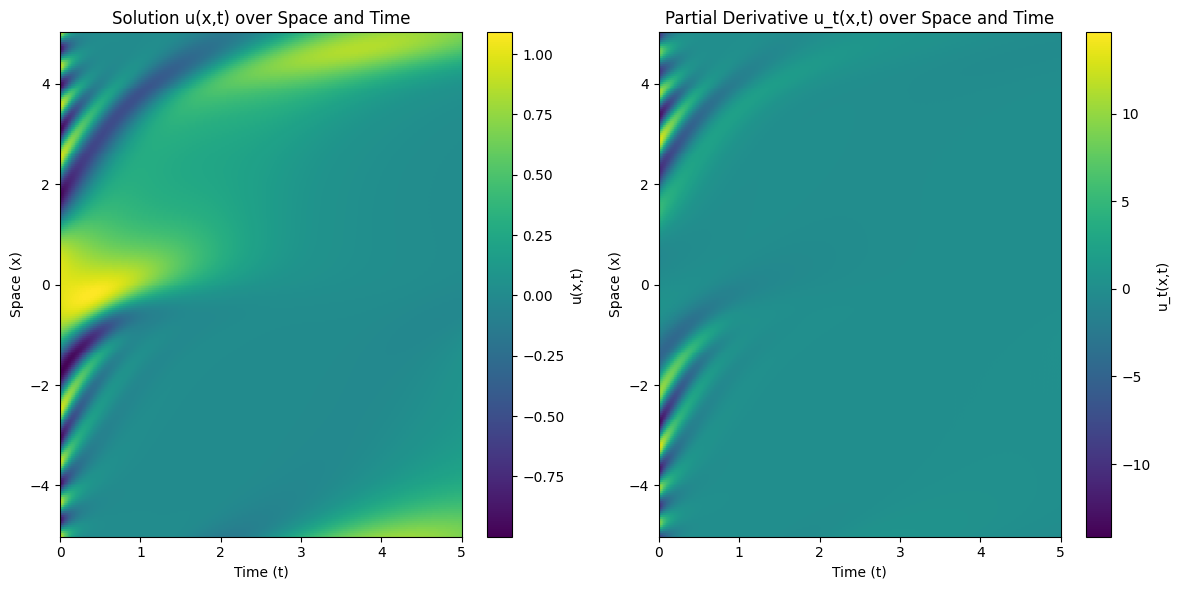

In [8]:
# Adjusting the PDESolver class and plotting both u(x,t) and u_t as requested.
import numpy as np
from scipy.fftpack import fft, ifft, fftfreq
from scipy.integrate import solve_ivp
from scipy.io import savemat
import matplotlib.pyplot as plt

class PDESolver:
    def __init__(self, f_x, epsilon, x_domain, t_span, u0):
        self.f_x = f_x
        self.epsilon = epsilon
        self.x_domain = x_domain
        self.t_span = t_span
        self.u0 = u0(x_domain)
        self.solution = None

    def compute_spectral_derivative(self, u_discrete):
        k = fftfreq(u_discrete.size, d=(self.x_domain[1] - self.x_domain[0]) / (2 * np.pi))
        u_derivative_discrete = ifft(1j * k * fft(u_discrete)).real
        return u_derivative_discrete

    def pde_system(self, t, u_discrete):
        u_x_discrete = self.compute_spectral_derivative(u_discrete)
        u_xx_discrete = self.compute_spectral_derivative(u_x_discrete)
        f_prime_x = np.gradient(self.f_x(self.x_domain), self.x_domain)
        du_dt_discrete = f_prime_x * u_discrete + self.f_x(self.x_domain) * u_x_discrete + self.epsilon * u_xx_discrete
        return du_dt_discrete

    def solve(self):
        self.solution = solve_ivp(self.pde_system, self.t_span, self.u0, method='RK45', t_eval=np.linspace(self.t_span[0], self.t_span[1], 512))
        return self.solution

    def compute_and_save_grid_values(self):
        # Initialize arrays to store the computed values
        u_values = self.solution.y
        u_t_values = np.empty_like(u_values)
        u_x_values = np.empty_like(u_values)
        u_xx_values = np.empty_like(u_values)

        for i, t in enumerate(self.solution.t):
            u_discrete = self.solution.y[:, i]
            u_x_discrete = self.compute_spectral_derivative(u_discrete)
            u_xx_discrete = self.compute_spectral_derivative(u_x_discrete)
            u_t_discrete = self.pde_system(t, u_discrete)
            
            u_t_values[:, i] = u_t_discrete
            u_x_values[:, i] = u_x_discrete
            u_xx_values[:, i] = u_xx_discrete
        
        f_x_values = self.f_x(self.x_domain)
        f_prime_x_values = np.gradient(f_x_values, self.x_domain)
        
        # Create a dictionary to store the data
        data = {
            't': self.solution.t,
            'x': self.x_domain,
            'u': u_values,
            'u_t': u_t_values,
            'u_x': u_x_values,
            'u_xx': u_xx_values,
            'f_x': f_x_values,
            'f_prime_x': f_prime_x_values
        }
        
        # Save the data to a .mat file
        mat_file_path = 'adv_diffu_grid_values.mat'
        savemat(mat_file_path, data)
        
        return data, mat_file_path

    def plot_solution(self):
        T, X = np.meshgrid(self.solution.t, self.x_domain)
        U = self.solution.y

        u_t_values = self.compute_and_save_grid_values()[0]['u_t']


        fig, axs = plt.subplots(1, 2, figsize=(12, 6))

        # Plotting u(x,t)
        c1 = axs[0].pcolormesh(T, X, U, shading='auto')
        fig.colorbar(c1, ax=axs[0], label='u(x,t)')
        axs[0].set_xlabel('Time (t)')
        axs[0].set_ylabel('Space (x)')
        axs[0].set_title('Solution u(x,t) over Space and Time')

        # Plotting u_t(x,t)
        c2 = axs[1].pcolormesh(T, X, u_t_values, shading='auto')
        fig.colorbar(c2, ax=axs[1], label='u_t(x,t)')
        axs[1].set_xlabel('Time (t)')
        axs[1].set_ylabel('Space (x)')
        axs[1].set_title('Partial Derivative u_t(x,t) over Space and Time')

        plt.tight_layout()

        plt.savefig('adv_diffu_solution.png')

# Initialize the PDE solver with the given parameters
pde_solver = PDESolver(
    f_x=lambda x: -1.5 + np.cos(2 * np.pi * x / 5), 
    epsilon=0.1, 
    x_domain=np.linspace(-5, 5, 256), 
    t_span=(0, 5), 
    u0=lambda x:1*np.cos(-x**2)
)

# Solve the PDE and plot the solutions
solution = pde_solver.solve()
pde_solver.plot_solution()


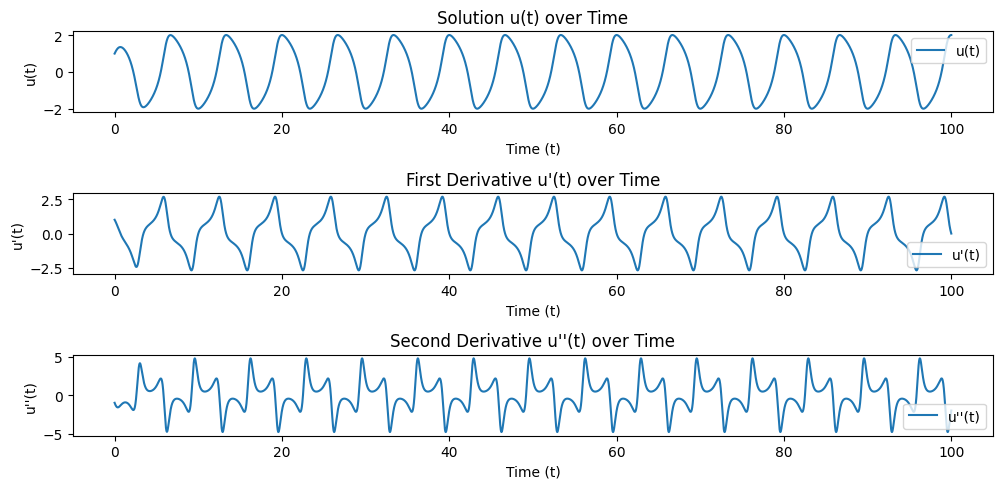

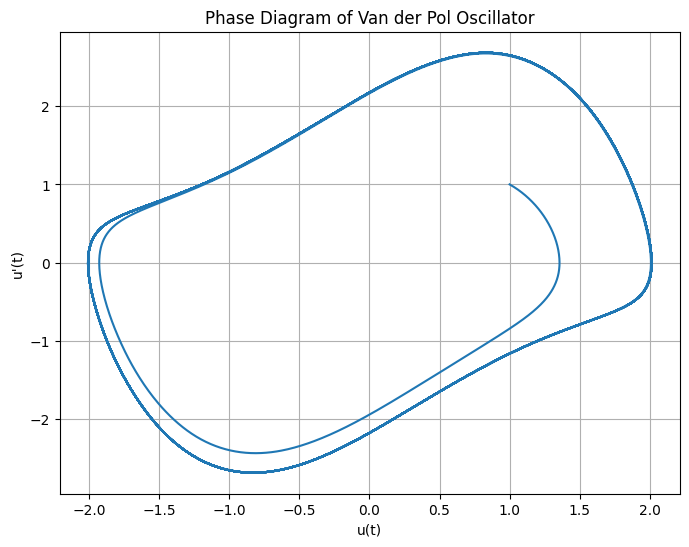

In [47]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

class VanDerPolSolver:
    def __init__(self, mu, t_span, u0, du0):
        self.mu = mu
        self.t_span = t_span
        self.initial_conditions = [u0, du0]

    def van_der_pol_system(self, t, y):
        u, v = y
        du_dt = v
        dv_dt = self.mu * (1 - u**2) * v - u
        return [du_dt, dv_dt]

    def solve(self):
        solution = solve_ivp(self.van_der_pol_system, self.t_span, self.initial_conditions, method='RK45', t_eval=np.linspace(self.t_span[0], self.t_span[1], 20000))
        return solution

    def plot_solution(self, solution):
        t = solution.t
        u = solution.y[0, :]
        du = solution.y[1, :]  # First derivative
        ddu = self.mu * (1 - u**2) * du - u  # Second derivative
        fig, axs = plt.subplots(3, 1, figsize=(10, 5))

        axs[0].plot(t, u, label='u(t)')
        axs[0].set_xlabel('Time (t)')
        axs[0].set_ylabel('u(t)')
        axs[0].set_title('Solution u(t) over Time')
        axs[0].legend()

        axs[1].plot(t, du, label="u'(t)")
        axs[1].set_xlabel('Time (t)')
        axs[1].set_ylabel("u'(t)")
        axs[1].set_title("First Derivative u'(t) over Time")
        axs[1].legend()

        axs[2].plot(t, ddu, label="u''(t)")
        axs[2].set_xlabel('Time (t)')
        axs[2].set_ylabel("u''(t)")
        axs[2].set_title("Second Derivative u''(t) over Time")
        axs[2].legend()
        plt.tight_layout()
        plt.figure(figsize=(8, 6))
        plt.plot(u, du)
        plt.xlabel('u(t)')
        plt.ylabel("u'(t)")
        plt.title("Phase Diagram of Van der Pol Oscillator")
        plt.grid(True)
        plt.show()

# Example usage
mu =1 # Van der Pol parameter
vdp_solver = VanDerPolSolver(mu, t_span=(0, 100), u0=1, du0=1)
solution = vdp_solver.solve()
vdp_solver.plot_solution(solution)

